In [1]:
import pandas as pd
from catboost import CatBoostClassifier
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, roc_auc_score
from typing import List, Dict
import matplotlib.pyplot as plt

In [2]:
# генератор метрик
def eval_metrics(y_test: pd.DataFrame, y_pred: pd.DataFrame, verbose: bool) -> List[float]:
    """
    :param y_test: test dataset
    :param y_pred: predicted dataset
    :param verbose: print scores flag
    :return: list of scores [Precision Score, Recall Score, F1 Score, Accuracy Score, ROC AUC]
    """
    pr_sc = round(precision_score(y_val, y_pred), 3)
    re_sc = round(recall_score(y_val, y_pred), 3)
    f1_sc = round(f1_score(y_val, y_pred), 3)
    ac_sc = round(accuracy_score(y_val, y_pred), 3)
    ra_sc = round(roc_auc_score(y_val, y_pred), 3)

    print('Precision Score: ', pr_sc)
    print('Recall Score: ', re_sc)
    print('F1 Score: ', f1_sc)
    print('Accuracy Score: ', ac_sc)
    print('ROC AUC: ', ra_sc)

    return [pr_sc, re_sc, f1_sc, ac_sc, ra_sc]

In [3]:
# предобработчик наборов данных
def load_datasets(X_filename: str, y_filename: str, X_val_filename: str, y_val_filename: str) -> List[pd.DataFrame]:
    """
    :param X_filename: path to csx with X data
    :param y_filename: path to csx with y data
    :param X_val_filename: path to csx with X_val data
    :param y_val_filename: path to csx with y_val data
    :return: list of pandas dataframes [X, y, X_val, y_val]
    """
    X = pd.read_csv(X_filename)
    y = pd.read_csv(y_filename)
    X_val = pd.read_csv(X_val_filename)
    y_val = pd.read_csv(y_val_filename)

    x_col_names = list(X.columns)
    x_col_names[0] = 'user_id'
    X.columns = x_col_names
    X_val.columns = x_col_names
    y = y.drop(columns=[list(y.columns)[0]])
    y_val = y_val.drop(columns=[list(y_val.columns)[0]])

    return [X, y, X_val, y_val]

In [4]:
# визуализация зависимости метрик от гиперпараметра "iterations"
def visualize_it(catboost_scores: pd.DataFrame) -> None:
    """
    :param catboost_scores: dataframe with index = iterations param value,
             metrics columns = ['Precision Score', 'Recall Score', 'F1 Score', 'Accuracy Score', 'ROC AUC']
    :return:
    """
    plt.figure(figsize=[15, 10])
    plt.plot(catboost_scores['Precision Score'], label=catboost_scores.columns[0])
    plt.plot(catboost_scores['Recall Score'], label=catboost_scores.columns[1])
    plt.plot(catboost_scores['F1 Score'], label=catboost_scores.columns[2])
    plt.plot(catboost_scores['Accuracy Score'], label=catboost_scores.columns[3])
    plt.plot(catboost_scores['ROC AUC'], label=catboost_scores.columns[4])
    plt.xlabel('Количество итераций (параметр "iterations")')
    plt.ylabel('Значение метрики')
    plt.title('Зависимость метрик качества от гиперпараметра "iterations"')
    plt.legend()
    plt.show()

In [21]:
# непосредственно catboost
def catboost_it(X: pd.DataFrame, y: pd.DataFrame, X_val: pd.DataFrame, y_val: pd.DataFrame, min_iterations: int,
                max_iterations: int, iteration_step: int, verbose: bool, category_columns: List[str]) -> pd.DataFrame:
    """
    :param iteration_step:
    :param category_columns:
    :param X: training set of values
    :param y: training set of results
    :param X_val: test set of values
    :param y_val: test set of results
    :param min_iterations: minimum value of catboost's iterations parameter
    :param max_iterations: max value of catboost's iterations parameter
    :param verbose: is needed to show iteration info
    :return: dataframe with index = iterations param value,
             metrics columns = ['Precision Score', 'Recall Score', 'F1 Score', 'Accuracy Score', 'ROC AUC']
    """
    if category_columns is None:
        category_columns = []
    else:
        for cat in category_columns:
            X[cat] = X[cat].astype(int)
    catboost_boost_results = dict()
    for i in range(min_iterations, max_iterations, iteration_step):
        catboost_model = CatBoostClassifier(iterations=i + 1, cat_features=category_columns)
        print(catboost_model.feature_names_)
        catboost_model.fit(X, y)
        prediction = catboost_model.predict(X_val)
        catboost_boost_results[i + 1] = eval_metrics(y_val, prediction, verbose)

    catboost_scores = pd.DataFrame(catboost_boost_results).T
    catboost_scores.columns = ['Precision Score', 'Recall Score', 'F1 Score', 'Accuracy Score', 'ROC AUC']

    return catboost_scores

## Набор данных "Первая итерация"

In [6]:
# загружаем данные
X, y, X_val, y_val = load_datasets('0_X.csv', '0_y.csv', '0_X_val.csv', '0_y_val.csv')

In [7]:
X

,user_id,REGION,TENURE,MONTANT,FREQUENCE_RECH,REVENUE,ARPU_SEGMENT,FREQUENCE,DATA_VOLUME,ON_NET,ORANGE,TIGO,ZONE1,ZONE2,REGULARITY,FREQ_TOP_PACK
0,957056,12.0,18.0,-0.638518,-0.718161,-0.718841,-0.718706,-0.747321,-0.252563,-0.315014,-0.377476,-0.332739,0.000000,0.000000,0.446632,0.000000
1,536962,8.0,24.0,-0.708945,-0.793489,-0.699894,-0.699898,-0.747321,-0.249717,-0.313873,-0.450555,0.000000,0.000000,-0.220128,0.581223,0.000000
2,1575854,0.0,24.0,0.002368,1.541680,0.190890,0.190749,1.702509,0.028720,-0.212311,-0.236189,0.454859,0.000000,0.000000,-0.091734,1.363902
3,1543057,9.0,24.0,0.699596,0.110447,0.698418,0.698556,0.613696,-0.252563,0.355982,-0.338500,-0.316987,-0.208879,0.000000,1.433635,-0.267198
4,1520724,14.0,24.0,-0.596262,-0.416849,-0.586770,-0.586634,-0.407067,-0.186736,-0.273933,-0.401836,-0.316987,0.000000,0.000000,0.715815,-0.593418
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1723233,73349,14.0,24.0,0.122094,-0.115537,0.206633,0.206631,0.001238,0.017487,-0.315014,-0.012078,0.785650,0.000000,0.000000,-0.271189,-0.348753
1723234,836489,11.0,24.0,0.000000,0.000000,0.000000,0.000000,0.000000,-0.251140,-0.292191,0.000000,0.000000,0.000000,0.000000,-1.123601,0.000000
1723235,491263,0.0,24.0,-0.004674,-0.040209,0.067875,0.067872,-0.134863,0.000000,-0.295615,-0.002334,0.360347,0.000000,0.000000,-0.226325,0.222132
1723236,491755,14.0,1.0,0.000000,0.000000,-0.767462,-0.767605,-0.883422,-0.252563,-0.313873,0.000000,0.000000,0.000000,0.000000,-0.989009,0.000000


In [8]:
y

,CHURN
0,0
1,0
2,0
3,0
4,0
...,...
1723233,1
1723234,0
1723235,0
1723236,1


In [28]:
X['REGION'] = X['REGION'].apply(int)
X_val['REGION'] = X_val['REGION'].apply(int)
X['TENURE'] = X['TENURE'].apply(int)
X_val['TENURE'] = X_val['TENURE'].apply(int)
catboost_model = CatBoostClassifier(iterations=1, cat_features=['REGION', 'TENURE'])
catboost_model.fit(X, y)
predict = catboost_model.predict(X_val)
print(f'ROC AUC:\n{round(roc_auc_score(y_val, predict), 3)}')


Learning rate set to 0.5
0:	learn: 0.4597954	total: 732ms	remaining: 0us


0.7458341632625153

In [22]:
catboost_scores = catboost_it(X, y, X_val, y_val, 1, 100, 10, True, ['REGION', 'TENURE'])
catboost_scores

None
Learning rate set to 0.5
0:	learn: 0.4597954	total: 858ms	remaining: 858ms
1:	learn: 0.3754781	total: 1.35s	remaining: 0us
Precision Score:  0.665
Recall Score:  0.55
F1 Score:  0.602
Accuracy Score:  0.864
ROC AUC:  0.743
None
Learning rate set to 0.5
0:	learn: 0.4597954	total: 745ms	remaining: 8.2s
1:	learn: 0.3754781	total: 1.2s	remaining: 5.99s
2:	learn: 0.3370238	total: 1.55s	remaining: 4.67s
3:	learn: 0.2943003	total: 1.95s	remaining: 3.9s
4:	learn: 0.2749666	total: 2.31s	remaining: 3.23s
5:	learn: 0.2648035	total: 2.69s	remaining: 2.69s
6:	learn: 0.2594335	total: 2.93s	remaining: 2.09s
7:	learn: 0.2568656	total: 3.17s	remaining: 1.59s
8:	learn: 0.2557171	total: 3.35s	remaining: 1.12s
9:	learn: 0.2553042	total: 3.51s	remaining: 702ms
10:	learn: 0.2543852	total: 3.82s	remaining: 347ms
11:	learn: 0.2539199	total: 4s	remaining: 0us
Precision Score:  0.687
Recall Score:  0.652
F1 Score:  0.669
Accuracy Score:  0.879
ROC AUC:  0.792
None
Learning rate set to 0.5
0:	learn: 0.45979

,Precision Score,Recall Score,F1 Score,Accuracy Score,ROC AUC
2,0.665,0.550,0.602,0.864,0.743
12,0.687,0.652,0.669,0.879,0.792
22,0.687,0.651,0.669,0.879,0.791
32,0.688,0.650,0.669,0.879,0.791
42,0.688,0.650,0.669,0.879,0.791
52,0.687,0.653,0.669,0.879,0.792
62,0.688,0.651,0.669,0.879,0.792
72,0.688,0.653,0.670,0.879,0.792
82,0.688,0.653,0.670,0.879,0.792
92,0.688,0.653,0.670,0.879,0.792


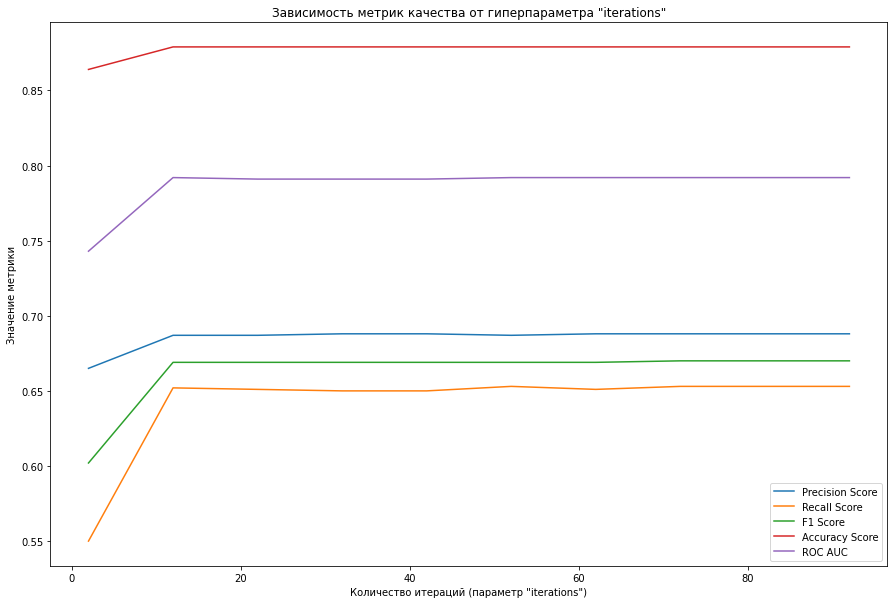

In [23]:
visualize_it(catboost_scores)

In [24]:
catboost_scores[catboost_scores['ROC AUC'] == catboost_scores['ROC AUC'].max()]

,Precision Score,Recall Score,F1 Score,Accuracy Score,ROC AUC
12,0.687,0.652,0.669,0.879,0.792
52,0.687,0.653,0.669,0.879,0.792
62,0.688,0.651,0.669,0.879,0.792
72,0.688,0.653,0.670,0.879,0.792
82,0.688,0.653,0.670,0.879,0.792
92,0.688,0.653,0.670,0.879,0.792


## Набор данных "Вторая итерация"

In [18]:
X, y, X_val, y_val = load_datasets('2_X.csv', '2_y.csv', '2_X_val.csv', '2_y_val.csv')

FileNotFoundError: [Errno 2] No such file or directory: '2_X.csv'